In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
# Import data into a database
origional_df = pd.read_csv("melb_data.csv")

In [3]:
origional_df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [4]:
# Creating a new df with just the variables needed
df = origional_df[["Suburb", "Rooms", "Type", "Price", "Bathroom", "Car", "BuildingArea"]]

In [5]:
df.shape

(13580, 7)

In [6]:
# Lets make sure everything is clean and nice
print(f"Duplicate rows before cleaning: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicate rows after cleaning: {df.duplicated().sum()}")


Duplicate rows before cleaning: 100
Duplicate rows after cleaning: 0


/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/3142257187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [7]:
missing_values = df.isnull().sum()
print("Missing values before handling:")
print (missing_values)

Missing values before handling:
Suburb             0
Rooms              0
Type               0
Price              0
Bathroom           0
Car               62
BuildingArea    6368
dtype: int64


We can see there are no duplicate rows anymore, that there are missing values, and that everything is unique. 
We can see that there are 13580 entries in this dataset and there are 62 entires missing car parking spaces data and 6,450 entires missing data about bulding areas. There are a few things we can do here, we can get rid of the entires missing car parking or find the average parking spaces for house size. For the entires missing data on budilding area, there are about 47% of the entires missing that data. That is to much data to be missing for just getting rid of the entries with missing data. For now, I am going to fill in th parking spot data with the average number of parking spots for each room size. 

In [8]:
# Calculate average number of car spots per room count
car_avg_by_room = df.groupby("Rooms")["Car"].mean()

# Function to apply to missing values
def impute_car(row):
    if pd.isna(row["Car"]):
        return car_avg_by_room.get(row["Rooms"], df["Car"].mean())  # fallback to overall mean if Rooms is unknown
    else:
        return row["Car"]

# Apply the function
df["Car"] = df.apply(impute_car, axis=1)

/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/11555879.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Car"] = df.apply(impute_car, axis=1)


In [9]:
# Seeing how it worked
missing_values = df.isnull().sum()
print("Missing values before handling:")
print (missing_values)

Missing values before handling:
Suburb             0
Rooms              0
Type               0
Price              0
Bathroom           0
Car                0
BuildingArea    6368
dtype: int64


Since there are so many entires missing the building area, I am going to use the number of rooms and bathrooms. I am going to do this by using lenear regression 

In [10]:
# Drop rows with missing BuildingArea or predictors
train_df = df.dropna(subset=["BuildingArea", "Rooms", "Bathroom"])

# Define predictors and target
X_train = train_df[["Rooms", "Bathroom"]]
y_train = train_df["BuildingArea"]

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
# Select rows where BuildingArea is missing but Rooms and Bathroom are available
missing_df = df[df["BuildingArea"].isna() & df["Rooms"].notna() & df["Bathroom"].notna()]

# Predict values
X_missing = missing_df[["Rooms", "Bathroom"]]
predicted_areas = model.predict(X_missing)

# Fill in the missing values
df.loc[missing_df.index, "BuildingArea"] = predicted_areas

In [14]:
# The only things I would like to change is the number of car parking spots. 
# There are full and half baths, so it makes no since when it says there are 2.07 baths
df["Car"] = df["Car"].round()

/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/1038845122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Car"] = df["Car"].round()


Now that there is no missing data, lets check the data types and how unique the data is. 

In [13]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}': {unique_values}\n")

Unique values in 'Suburb': ['Abbotsford' 'Airport West' 'Albert Park' 'Alphington' 'Altona'
 'Altona North' 'Armadale' 'Ascot Vale' 'Ashburton' 'Ashwood'
 'Avondale Heights' 'Balaclava' 'Balwyn' 'Balwyn North' 'Bentleigh'
 'Bentleigh East' 'Box Hill' 'Braybrook' 'Brighton' 'Brighton East'
 'Brunswick' 'Brunswick West' 'Bulleen' 'Burwood' 'Camberwell'
 'Canterbury' 'Carlton North' 'Carnegie' 'Caulfield' 'Caulfield North'
 'Caulfield South' 'Chadstone' 'Clifton Hill' 'Coburg' 'Coburg North'
 'Collingwood' 'Doncaster' 'Eaglemont' 'Elsternwick' 'Elwood' 'Essendon'
 'Essendon North' 'Fairfield' 'Fitzroy' 'Fitzroy North' 'Flemington'
 'Footscray' 'Glen Iris' 'Glenroy' 'Gowanbrae' 'Hadfield' 'Hampton'
 'Hampton East' 'Hawthorn' 'Heidelberg Heights' 'Heidelberg West'
 'Hughesdale' 'Ivanhoe' 'Kealba' 'Keilor East' 'Kensington' 'Kew'
 'Kew East' 'Kooyong' 'Maidstone' 'Malvern' 'Malvern East' 'Maribyrnong'
 'Melbourne' 'Middle Park' 'Mont Albert' 'Moonee Ponds' 'Moorabbin'
 'Newport' 'Niddrie' 'N

In [15]:
# Now we check the data types
data_types = df.dtypes
print(data_types)

Suburb           object
Rooms             int64
Type             object
Price           float64
Bathroom        float64
Car             float64
BuildingArea    float64
dtype: object


In [16]:
# The last thing I am going to do is change the variable names to explain more of what it tells you
df.rename(columns={"Rooms": "NumRoom", "Bathroom": "NumBathroom", "Car": "NumParkingSpots", "Type": "TypeOfHome"}, inplace=True)

/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/1754741954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Rooms": "NumRoom", "Bathroom": "NumBathroom", "Car": "NumParkingSpots", "Type": "TypeOfHome"}, inplace=True)


In [17]:
df.head()

,Suburb,NumRoom,TypeOfHome,Price,NumBathroom,NumParkingSpots,BuildingArea
0,Abbotsford,2,h,1480000.0,1.0,1.0,77.539393
1,Abbotsford,2,h,1035000.0,1.0,0.0,79.000000
2,Abbotsford,3,h,1465000.0,2.0,0.0,150.000000
3,Abbotsford,3,h,850000.0,2.0,1.0,170.448022
4,Abbotsford,4,h,1600000.0,1.0,2.0,142.000000


In [18]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply the label encoding to the 'Suburb' column
df['Suburb_encoded'] = label_encoder.fit_transform(df['Suburb'])

# Check the new DataFrame
print(df[['Suburb', 'Suburb_encoded']].head())

# Apply the label encoding to the 'TypeOfHome' column
df['TypeOfHome_encoded'] = label_encoder.fit_transform(df['TypeOfHome'])

# Check the new DataFrame
print(df[['TypeOfHome', 'TypeOfHome_encoded']].head())

       Suburb  Suburb_encoded
0  Abbotsford               0
1  Abbotsford               0
2  Abbotsford               0
3  Abbotsford               0
4  Abbotsford               0
  TypeOfHome  TypeOfHome_encoded
0          h                   0
1          h                   0
2          h                   0
3          h                   0
4          h                   0


/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/1521582323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Suburb_encoded'] = label_encoder.fit_transform(df['Suburb'])
/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_53702/1521582323.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TypeOfHome_encoded'] = label_encoder.fit_transform(df['TypeOfHome'])


In [19]:
# Drop the original 'Suburb' and 'TypeOfHome' columns
df = df.drop(['Suburb', 'TypeOfHome'], axis=1)

# Check the updated DataFrame
df.head()

,NumRoom,Price,NumBathroom,NumParkingSpots,BuildingArea,Suburb_encoded,TypeOfHome_encoded
0,2,1480000.0,1.0,1.0,77.539393,0,0
1,2,1035000.0,1.0,0.0,79.000000,0,0
2,3,1465000.0,2.0,0.0,150.000000,0,0
3,3,850000.0,2.0,1.0,170.448022,0,0
4,4,1600000.0,1.0,2.0,142.000000,0,0


In [20]:
# So now that everything is clean and tidy, lets save the clean df
df.to_csv("clean_df.csv", index=False)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


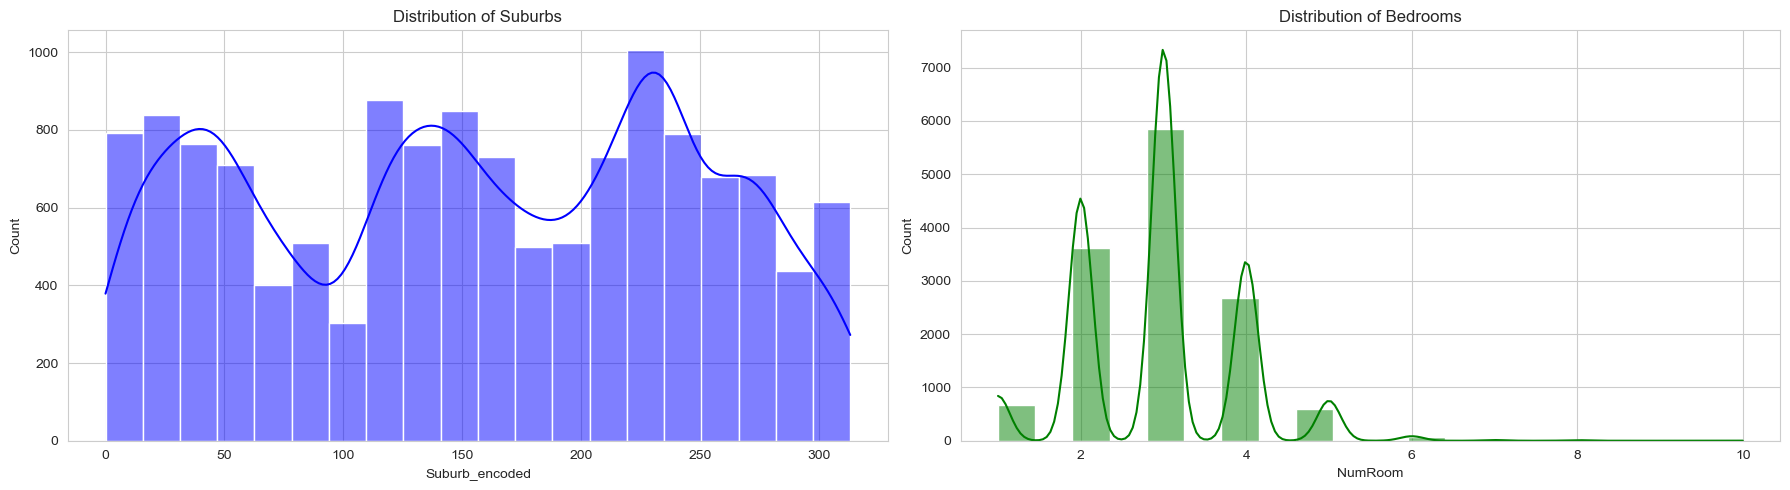

In [21]:
# I want to see how each variable is distributed
# Univariate Visualizations
# Set style
sns.set_style("whitegrid")

# Create subplots for univariate visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Histogram for Suburbs
sns.histplot(df["Suburb_encoded"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Suburbs")

# Histogram for Bedrooms
sns.histplot(df["NumRoom"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Bedrooms")

plt.tight_layout()
plt.show()

From the two graphs above we can see that the suburbs are everywhere. While there are several that are occur more at a higher rate, there are also several that dont occur often. 
We can also see that most homes in Melburne have 3 bedrooms, followed by 2, 4, 1, 5, 6, and then 7-10 bedrooms occur the least often.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


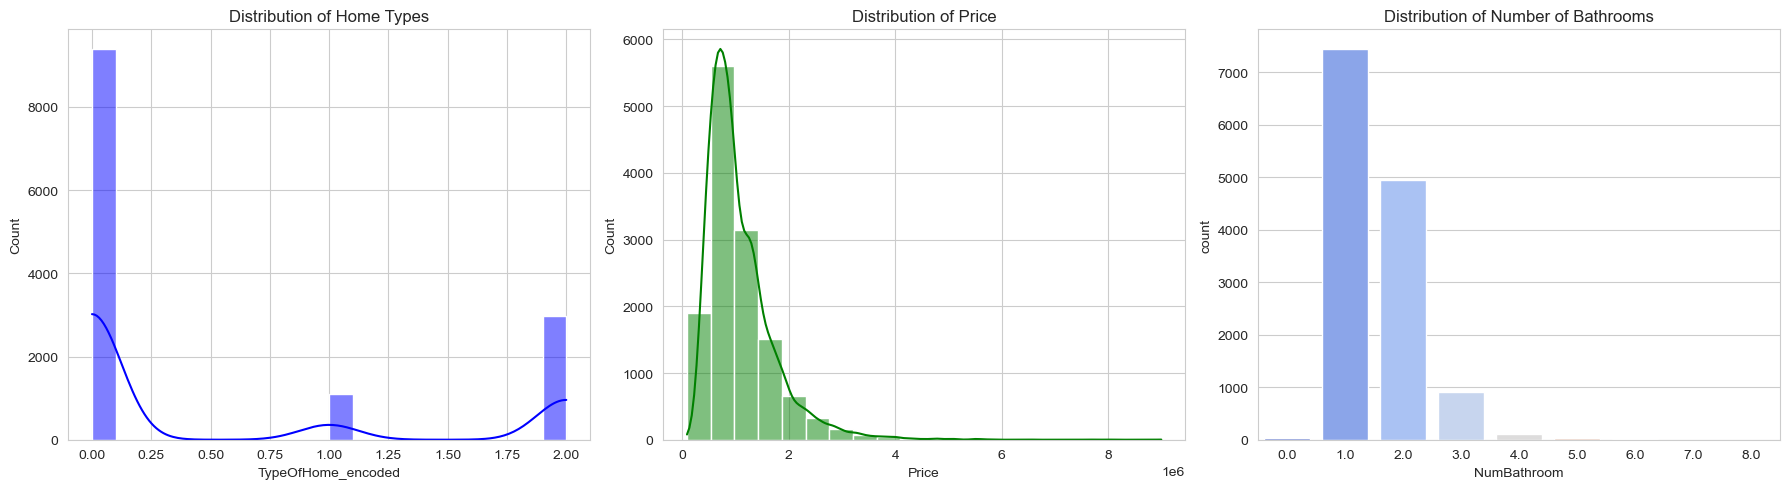

In [22]:
# Set style
sns.set_style("whitegrid")

# Create subplots for univariate visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for Home Types
sns.histplot(df["TypeOfHome_encoded"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Home Types")

# Histogram for Price
sns.histplot(df["Price"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Price")

# Histogram for NumBathroom
sns.countplot(x=df["NumBathroom"], ax=axes[2], palette="coolwarm")
axes[2].set_title("Distribution of Number of Bathrooms")

plt.tight_layout()
plt.show()

From the graphs above, we see that most home are in the 0 (h) category, that means most homes are houses, cottages, villas, semis, or terraces. Second most occuring is the 2 (u) cateogry, meaning they are a unit or a duplex. The least common is the 1 (t) category, which means it is a townhouse. 
The house pricing is a left leaning bell curve. This shows that most homes are on the cheaper side, with the more expensive ones being less popular. 
With the distribution of bathrooms, we can see that most homes have just 1 bathroom. With the second most popular being 2 bathrooms, 3, then 4. There are some homes with no bathrooms or have 5 or more bathrooms. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


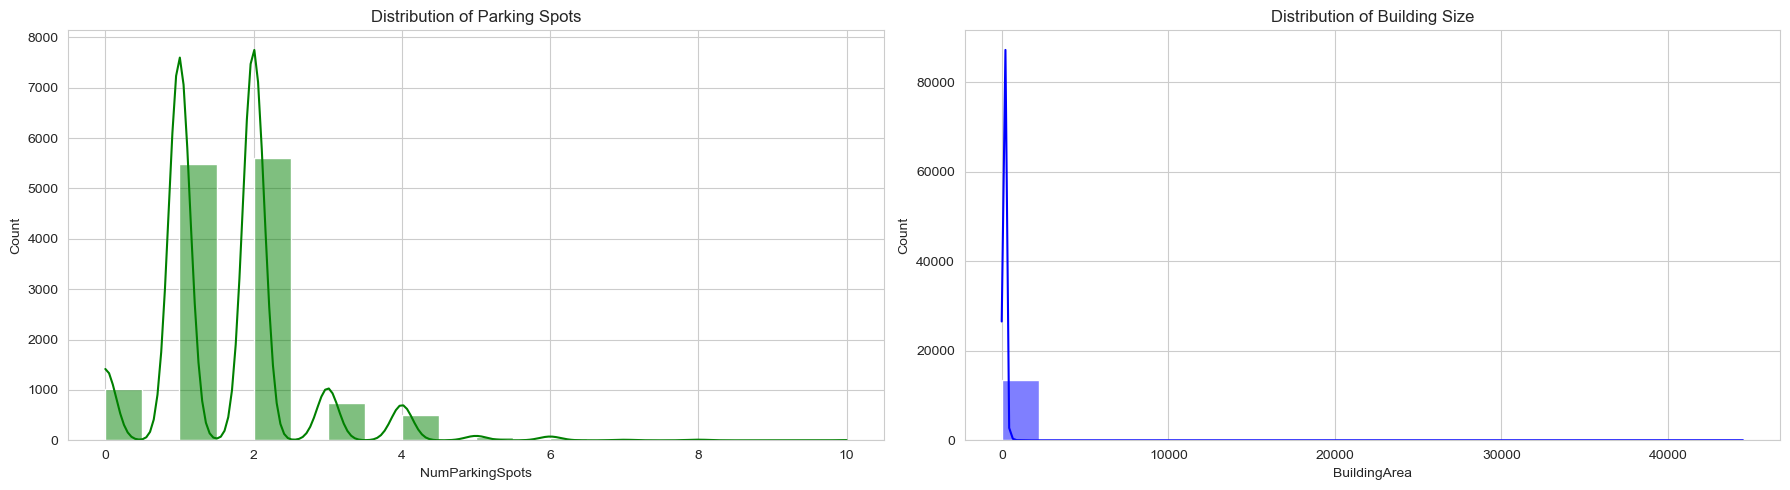

In [23]:
# Set style
sns.set_style("whitegrid")

# Create subplots for univariate visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Histogram for Parking spots
sns.histplot(df["NumParkingSpots"], bins=20, kde=True, ax=axes[0], color="green")
axes[0].set_title("Distribution of Parking Spots")

# Histogram for Building Area
sns.histplot(df["BuildingArea"], bins=20, kde=True, ax=axes[1], color="blue")
axes[1].set_title("Distribution of Building Size")

plt.tight_layout()
plt.show()

With the distribution of parking spots, most homes have 2 parking spots, fillows shortly by just 1. Some homes have no parking spots, some have 3, and some have 4. There are some homes with 5 or more, but they do not occur very often. 
Most homes in Melburn are less than 10,000 squared meters. While there are bigger homes, they are not common.

In [24]:
df_cleaned = df

In [25]:
# Split into training (80%) and test (20%) datasets
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Save the datasets
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("Training and test datasets saved.")

Training and test datasets saved.


In [26]:
# Define the independent and dependent variables
X_train = train_df[['Suburb_encoded', 'NumRoom', 'TypeOfHome_encoded', 'NumBathroom', 'NumParkingSpots', 'BuildingArea']]
y_train = train_df['Price']
X_test = test_df[['Suburb_encoded', 'NumRoom', 'TypeOfHome_encoded', 'NumBathroom', 'NumParkingSpots', 'BuildingArea']]
y_test = test_df['Price']

# Add constant for statsmodels OLS regression
X_train_sm = sm.add_constant(X_train)

# Fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     937.4
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        17:09:34   Log-Likelihood:            -1.5733e+05
No. Observations:               10784   AIC:                         3.147e+05
Df Residuals:                   10777   BIC:                         3.147e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.286e+05   2.41

From the OLS graph above, just by looking at the P values we can see the variables that are the most statistically significant. Since The number of parking spots have a p-value of 0.126 and since building area p value is 0.190 we can see they are not statistically significant. 

In [27]:
# Drop insignificant features
X_train = X_train.drop(columns=['NumParkingSpots', 'BuildingArea'])
X_test = X_test.drop(columns=['NumParkingSpots', 'BuildingArea'])

# Save the final feature names
final_features = X_train.columns.tolist()

# Add constant to both train and test
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test[final_features])  # match columns

# Fit the model
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

# Make predictions
y_train_pred = ols_model.predict(X_train_sm)
y_test_pred = ols_model.predict(X_test_sm)


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     1406.
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        17:09:34   Log-Likelihood:            -1.5733e+05
No. Observations:               10784   AIC:                         3.147e+05
Df Residuals:                   10779   BIC:                         3.147e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.267e+05   2.38

In [28]:
# Make predictions
y_train_pred = ols_model.predict(X_train_sm)
y_test_pred = ols_model.predict(X_test_sm)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 274919979168.6637
Testing MSE: 249688555454.4617
